<a href="https://colab.research.google.com/github/zigzagw/relex_homework/blob/main/forecast_MLP_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout,LeakyReLU
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import mean_squared_error
from math import sqrt
#from datetime import datetime

In [41]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
#drive.flush_and_unmount()
#print('All changes made in this colab session should now be visible in Drive.')
#/content/drive/My Drive

In [43]:
!ls '/content/drive/My Drive/21mai/relex/forecasting/Data'


Test_X.csv  Test_Y.csv	Train_XY.csv


### Training dataset: overview

In [44]:
df = pd.read_csv('/content/drive/My Drive/21mai/relex/forecasting/Data/Train_XY.csv', sep = ';')
print(df.shape)
df.set_index('dates', inplace=True)
df.sort_values('dates',inplace=True)
df.head()

(3895, 5)


,product,quantity,price,promotion
dates,,,,
2017-01-01,3,16.0,111.99,NaN
2017-01-01,2,84.0,20.00,NaN
2017-01-01,4,8.2,19.99,NaN
2017-01-02,2,78.0,20.00,NaN
2017-01-02,4,11.7,19.99,NaN


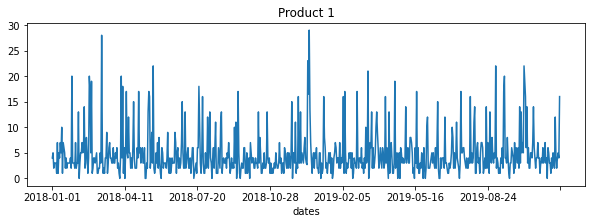

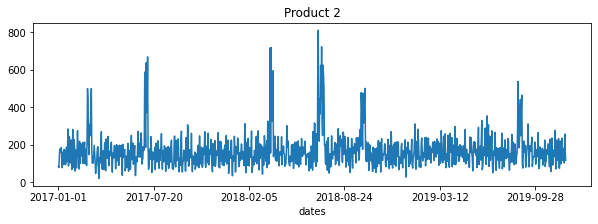

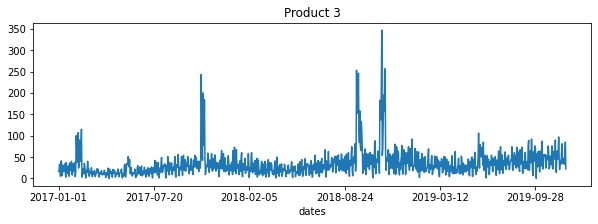

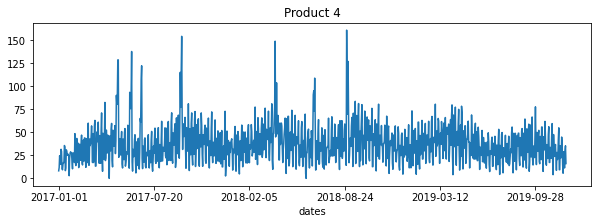

In [45]:
for i in range(1,5):
  prod = df.loc[df['product'] == i]['quantity']
  prod.plot(figsize=(10, 3))
  plt.title(f'Product {i}')
  plt.show()

### Data preprocessing for a selected product

In [385]:
num_product = 4 # choise product number for Forecast (1-4)

In [386]:
df = pd.read_csv('/content/drive/My Drive/21mai/relex/forecasting/Data/Train_XY.csv', sep = ';')
print (df.shape)
print (f"dates: {df['dates'].min()} {df['dates'].max()}")

#Separate dates for future plotting
train_dates = pd.to_datetime(df['dates'])

df.set_index('dates', inplace=True)
df.sort_values('dates',inplace=True)
#Transform promotion Types to integers
df['promotion'] = df['promotion'].fillna('Type_0')

lst = df['promotion'].unique()
promo_to_int_dict = dict(zip(lst,range(len(lst))))  
print(promo_to_int_dict)
df['promotion'] = df['promotion'].map(promo_to_int_dict)
df.tail(5)

(3895, 5)
dates: 2017-01-01 2019-12-01
{'Type_0': 0, 'Type_2': 1, 'Type_1': 2, 'Type_4': 3, 'Type_7': 4, 'Type_3': 5, 'Type_5': 6, 'Type_6': 7, 'Type_1, Type_2': 8}


,product,quantity,price,promotion
dates,,,,
2019-11-30,1,4.0,5.50,0
2019-12-01,2,117.0,16.00,0
2019-12-01,3,22.0,78.99,0
2019-12-01,1,16.0,5.50,0
2019-12-01,4,16.1,19.99,0


In [387]:
# Select data for specific product
prod_train = df.loc[df['product'] == num_product]
#print(prod_train['promotion'].value_counts())
prod_train.head()

,product,quantity,price,promotion
dates,,,,
2017-01-01,4,8.2,19.99,0
2017-01-02,4,11.7,19.99,0
2017-01-03,4,24.6,19.99,0
2017-01-04,4,17.6,19.99,0
2017-01-05,4,15.2,19.99,0


In [ ]:
#Variables for training
cols = list(prod_train)[1:4]
for i in range(len(cols)):
  print(cols[i])
  print(prod_train[cols[i]].unique())

df_for_training = prod_train[cols].astype(float)

In [389]:
df_for_training.tail(4)

,quantity,price,promotion
dates,,,
2019-11-28,11.3,19.99,0.0
2019-11-29,29.0,19.99,0.0
2019-11-30,35.4,19.99,0.0
2019-12-01,16.1,19.99,0.0


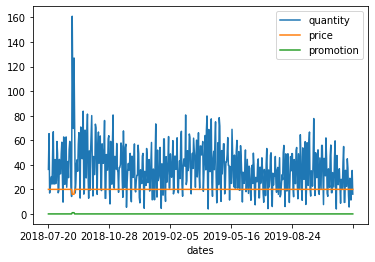

In [390]:
# values are need to be normalized later
df_for_plot=df_for_training.tail(500)
df_for_plot.plot.line()


*   For some products two columns in TrainX is unuseful since they are constant. So, mostly quantities in past days will participate in the forecast
*   In this case the task becomes a time series forecast. To improve accuracy of the forecast we can use use multiple quantaty values from histoty.


In [391]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)
#df_for_training_scaled = df_for_training.values


In [392]:
print(df_for_training_scaled.shape)

(1065, 3)


### Train LSTM model for each product

In [393]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 2. We will make timesteps = 3. 
#With this, the resultant n_samples is 5 (as the input data has 9 rows).
trainX = []
trainY = []

n_future = 1   # Number of days we want to predict into the future
n_past = 14     # Number of past days we want to use to predict the future

for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (1051, 14, 3).
trainY shape == (1051, 1).


In [394]:
print(np.min(trainX[:,2]),np.max(trainX[:,2]))
print(np.min(trainX[:,1]),np.max(trainX[:,1]))
print(np.min(trainX[:,0]),np.max(trainX[:,0]))
print(trainX[-2:])
print(trainY[-2:])

-7.020231499169292 10.279385119253956
-7.020231499169292 10.279385119253956
-7.020231499169292 10.279385119253956
[[[ 0.83943815  0.17789535 -0.15820901]
  [-1.35382168  0.17789535 -0.15820901]
  [-1.35382168  0.17789535 -0.15820901]
  [-0.09571     0.17789535 -0.15820901]
  [-0.72235567  0.17789535 -0.15820901]
  [-0.72235567  0.17789535 -0.15820901]
  [ 0.35740302  0.17789535 -0.15820901]
  [-0.00412332  0.17789535 -0.15820901]
  [-1.08388201  0.17789535 -0.15820901]
  [-1.53699503  0.17789535 -0.15820901]
  [-0.40903283  0.17789535 -0.15820901]
  [-0.48615845  0.17789535 -0.15820901]
  [-1.26223501  0.17789535 -0.15820901]
  [-0.40903283  0.17789535 -0.15820901]]

 [[-1.35382168  0.17789535 -0.15820901]
  [-1.35382168  0.17789535 -0.15820901]
  [-0.09571     0.17789535 -0.15820901]
  [-0.72235567  0.17789535 -0.15820901]
  [-0.72235567  0.17789535 -0.15820901]
  [ 0.35740302  0.17789535 -0.15820901]
  [-0.00412332  0.17789535 -0.15820901]
  [-1.08388201  0.17789535 -0.15820901]
  [-

In [395]:
# define Autoencoder model
import tensorflow as tf
model = Sequential()
model.add(LSTM(32, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LeakyReLU())
model.add(LSTM(16, return_sequences=False))
model.add(LeakyReLU())
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))


initial_learning_rate=1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

model.compile(optimizer=optimizer, loss='mse')
model.summary()

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_50 (LSTM)               (None, 14, 32)            4608      
_________________________________________________________________
leaky_re_lu_115 (LeakyReLU)  (None, 14, 32)            0         
_________________________________________________________________
lstm_51 (LSTM)               (None, 16)                3136      
_________________________________________________________________
leaky_re_lu_116 (LeakyReLU)  (None, 16)                0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_131 (Dense)            (None, 1)                 17        
Total params: 7,761
Trainable params: 7,761
Non-trainable params: 0
___________________________________________________

In [396]:
# fit model
history = model.fit(trainX, trainY, epochs=30, batch_size=8, validation_split=0.1, verbose=1)


Epoch 1/30
119/119 [==============================] - 6s 20ms/step - loss: 0.8654 - val_loss: 0.5054
Epoch 2/30
119/119 [==============================] - 1s 11ms/step - loss: 0.8283 - val_loss: 0.4301
Epoch 3/30
119/119 [==============================] - 1s 11ms/step - loss: 0.7636 - val_loss: 0.4108
Epoch 4/30
119/119 [==============================] - 1s 11ms/step - loss: 0.7315 - val_loss: 0.4310
Epoch 5/30
119/119 [==============================] - 1s 11ms/step - loss: 0.7440 - val_loss: 0.3615
Epoch 6/30
119/119 [==============================] - 1s 12ms/step - loss: 0.6299 - val_loss: 0.3920
Epoch 7/30
119/119 [==============================] - 1s 11ms/step - loss: 0.5483 - val_loss: 0.3116
Epoch 8/30
119/119 [==============================] - 1s 11ms/step - loss: 0.5545 - val_loss: 0.2921
Epoch 9/30
119/119 [==============================] - 1s 11ms/step - loss: 0.5563 - val_loss: 0.3360
Epoch 10/30
119/119 [==============================] - 1s 11ms/step - loss: 0.4731 - val_lo

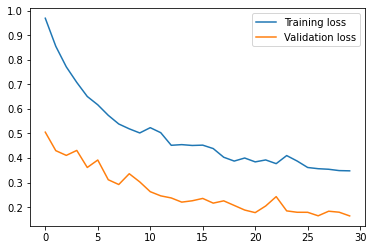

In [397]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [398]:
#Forecasting...
#Start with the last day in training date and predict future...
n_future=30  #Redefining n_future to extend prediction dates beyond original n_future dates...
forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=n_future+1, freq='1d').tolist()[1:]

In [399]:
forecast = model.predict(trainX[-n_future:]) #forecast 

In [400]:
print(forecast.shape)

(30, 1)


In [401]:
#Perform inverse transformation to rescale back to original range
#Since we used 3 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 3 times and discard them after inverse transform
forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]


In [402]:
# Convert timestamp to date
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())

In [403]:
df_forecast = pd.DataFrame({'dates':np.array(forecast_dates), 'quantity':y_pred_future})
df_forecast['dates']=pd.to_datetime(df_forecast['dates'])
df_forecast.head(5)

,dates,quantity
0,2019-12-02,50.910702
1,2019-12-03,19.699957
2,2019-12-04,16.404833
3,2019-12-05,36.902470
4,2019-12-06,29.209970


In [404]:
df_testY = pd.read_csv('/content/drive/My Drive/21mai/relex/forecasting/Data/Test_Y.csv', sep = ';')
df_testY['dates'] = pd.to_datetime(df_testY['dates'])
df_testY.sort_values('dates',inplace=True)
prod_testY = df_testY.loc[df_testY['product'] == num_product][['dates','quantity']]
print(prod_testY.shape)
prod_testY.head(5)

(30, 2)


,dates,quantity
90,2019-12-02,9.7
91,2019-12-03,25.0
92,2019-12-04,9.7
93,2019-12-05,23.6
94,2019-12-06,31.9


### Forecast for each Product with LSTM

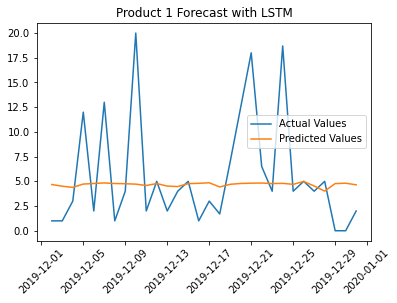

Test RMSE: 5.575


In [273]:
# Product 1
plt.plot(prod_testY['dates'], prod_testY['quantity'], label="Actual Values")
plt.plot(df_forecast['dates'], df_forecast['quantity'], label="Predicted Values")
plt.xticks(rotation = 45)
plt.ylabel
plt.legend()
plt.title(f'Product {num_product} Forecast with LSTM')
plt.show()
# evaluate forecasts
rmse = sqrt(mean_squared_error(prod_testY['quantity'],df_forecast['quantity']))
print('Test RMSE: %.3f' % rmse)

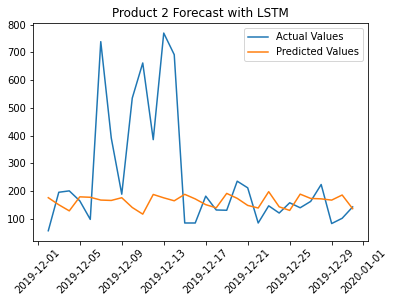

Test RMSE: 230.200


In [295]:
# Product 2
plt.plot(prod_testY['dates'], prod_testY['quantity'], label="Actual Values")
plt.plot(df_forecast['dates'], df_forecast['quantity'], label="Predicted Values")
plt.xticks(rotation = 45)
plt.ylabel
plt.legend()
plt.title(f'Product {num_product} Forecast with LSTM')
plt.show()
# evaluate forecasts
rmse = sqrt(mean_squared_error(prod_testY['quantity'],df_forecast['quantity']))
print('Test RMSE: %.3f' % rmse)

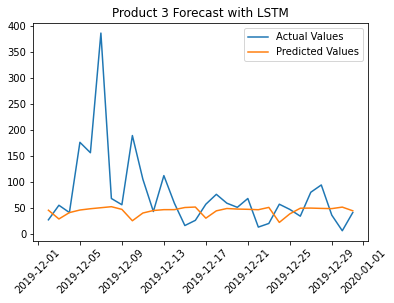

Test RMSE: 79.799


In [348]:
# Product 3
plt.plot(prod_testY['dates'], prod_testY['quantity'], label="Actual Values")
plt.plot(df_forecast['dates'], df_forecast['quantity'], label="Predicted Values")
plt.xticks(rotation = 45)
plt.ylabel
plt.legend()
plt.title(f'Product {num_product} Forecast with LSTM')
plt.show()
# evaluate forecasts
rmse = sqrt(mean_squared_error(prod_testY['quantity'],df_forecast['quantity']))
print('Test RMSE: %.3f' % rmse)

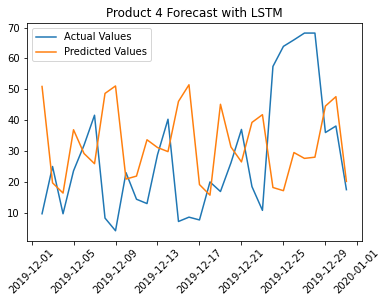

Test RMSE: 26.417


In [405]:
# Product 4
plt.plot(prod_testY['dates'], prod_testY['quantity'], label="Actual Values")
plt.plot(df_forecast['dates'], df_forecast['quantity'], label="Predicted Values")
plt.xticks(rotation = 45)
plt.ylabel
plt.legend()
plt.title(f'Product {num_product} Forecast with LSTM')
plt.show()
# evaluate forecasts
rmse = sqrt(mean_squared_error(prod_testY['quantity'],df_forecast['quantity']))
print('Test RMSE: %.3f' % rmse)

### Train MLP model for each product

In [406]:
#As required for MLP networks, we require to reshape an input data into n_samples x n_features. 
#In this example, the n_features is 2. We will make timesteps = 3. 
#With this, the resultant n_samples is 5 (as the input data has 9 rows).
trainX = []
trainY = []

n_future = 1   # Number of days we want to predict into the future
n_past = 7     # Number of past days we want to use to predict the future

for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)
print('trainX shape == {}.'.format(trainX.shape))
#trainX = trainX.reshape((-1, 9))
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (1058, 7).
trainX shape == (1058, 7).
trainY shape == (1058, 1).


In [407]:
print(np.min(trainX[:,2]),np.max(trainX[:,2]))
print(np.min(trainX[:,1]),np.max(trainX[:,1]))
print(np.min(trainX[:,0]),np.max(trainX[:,0]))
print(trainX[-5:])
print(trainY[-5:])

-1.8069347045636859 5.9538308643320486
-1.8069347045636859 5.9538308643320486
-1.8069347045636859 5.9538308643320486
[[-0.72235567 -0.72235567  0.35740302 -0.00412332 -1.08388201 -1.53699503
  -0.40903283]
 [-0.72235567  0.35740302 -0.00412332 -1.08388201 -1.53699503 -0.40903283
  -0.48615845]
 [ 0.35740302 -0.00412332 -1.08388201 -1.53699503 -0.40903283 -0.48615845
  -1.26223501]
 [-0.00412332 -1.08388201 -1.53699503 -0.40903283 -0.48615845 -1.26223501
  -0.40903283]
 [-1.08388201 -1.53699503 -0.40903283 -0.48615845 -1.26223501 -0.40903283
  -0.10053035]]
[[-0.48615845]
 [-1.26223501]
 [-0.40903283]
 [-0.10053035]
 [-1.03085815]]


In [408]:
# define MLP model
import tensorflow as tf

# Create the model
model = Sequential()
input_shape = (trainX.shape[1],)
model.add(Dense(8, input_shape=input_shape)) #, activation='relu'
model.add(LeakyReLU())
model.add(Dense(8))
model.add(LeakyReLU())
model.add(Dense(8))
model.add(LeakyReLU())
model.add(Dense(1, activation='linear'))

initial_learning_rate=1e-3

optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

model.compile(optimizer=optimizer, loss='mse')
model.summary()

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_132 (Dense)            (None, 8)                 64        
_________________________________________________________________
leaky_re_lu_117 (LeakyReLU)  (None, 8)                 0         
_________________________________________________________________
dense_133 (Dense)            (None, 8)                 72        
_________________________________________________________________
leaky_re_lu_118 (LeakyReLU)  (None, 8)                 0         
_________________________________________________________________
dense_134 (Dense)            (None, 8)                 72        
_________________________________________________________________
leaky_re_lu_119 (LeakyReLU)  (None, 8)                 0         
_________________________________________________________________
dense_135 (Dense)            (None, 1)               

In [409]:
# fit model
history = model.fit(trainX, trainY, epochs=50, batch_size=8, validation_split=0.1, verbose=1)


Epoch 1/50
119/119 [==============================] - 1s 4ms/step - loss: 1.1502 - val_loss: 0.4661
Epoch 2/50
119/119 [==============================] - 0s 2ms/step - loss: 0.6764 - val_loss: 0.2574
Epoch 3/50
119/119 [==============================] - 0s 1ms/step - loss: 0.6416 - val_loss: 0.2194
Epoch 4/50
119/119 [==============================] - 0s 1ms/step - loss: 0.5536 - val_loss: 0.2067
Epoch 5/50
119/119 [==============================] - 0s 1ms/step - loss: 0.4551 - val_loss: 0.2061
Epoch 6/50
119/119 [==============================] - 0s 1ms/step - loss: 0.4603 - val_loss: 0.1997
Epoch 7/50
119/119 [==============================] - 0s 2ms/step - loss: 0.4266 - val_loss: 0.2099
Epoch 8/50
119/119 [==============================] - 0s 1ms/step - loss: 0.4148 - val_loss: 0.1981
Epoch 9/50
119/119 [==============================] - 0s 1ms/step - loss: 0.4092 - val_loss: 0.1929
Epoch 10/50
119/119 [==============================] - 0s 1ms/step - loss: 0.4361 - val_loss: 0.2030

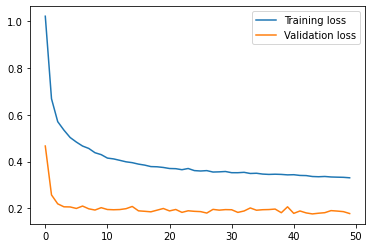

In [410]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [411]:
x_history = trainX[-1]
x_history = x_history.reshape(1,-1)  
y_pred = []       
for t in range(30):
  pred = model.predict(x_history)
  y_pred.append(pred[0,0])
  x_history = np.roll(x_history, -1, axis=1)
  x_history[0,-1] = pred


In [412]:
forecast = np.array(y_pred)
forecast = forecast.reshape(-1,1)
print ('forecast = ', forecast)
print(forecast.shape)

forecast =  [[-1.0687344 ]
 [-1.1035261 ]
 [-0.0944208 ]
 [-0.48076603]
 [-0.9356704 ]
 [-0.4056225 ]
 [-0.10505056]
 [-0.9318349 ]
 [-0.9142014 ]
 [-0.06258617]
 [-0.4989876 ]
 [-0.8074874 ]
 [-0.4378129 ]
 [-0.18966255]
 [-0.84540385]
 [-0.8137545 ]
 [-0.12336285]
 [-0.56976455]
 [-0.7663025 ]
 [-0.4642738 ]
 [-0.31721652]
 [-0.8132194 ]
 [-0.75390065]
 [-0.2126025 ]
 [-0.6702188 ]
 [-0.7629126 ]
 [-0.4682949 ]
 [-0.46905205]
 [-0.80937445]
 [-0.6954405 ]]
(30, 1)


In [413]:
#Perform inverse transformation to rescale back to original range
#Since we used 3 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 3 times and discard them after inverse transform
forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

In [414]:
# Convert timestamp to date
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())

In [415]:
df_forecast = pd.DataFrame({'dates':np.array(forecast_dates), 'quantity':y_pred_future})
df_forecast['dates']=pd.to_datetime(df_forecast['dates'])
df_forecast.head(5)

,dates,quantity
0,2019-12-02,15.314242
1,2019-12-03,14.592475
2,2019-12-04,35.526745
3,2019-12-05,27.511868
4,2019-12-06,18.074707


In [416]:
df_testY = pd.read_csv('/content/drive/My Drive/21mai/relex/forecasting/Data/Test_Y.csv', sep = ';')
df_testY['dates'] = pd.to_datetime(df_testY['dates'])
df_testY.sort_values('dates',inplace=True)
prod_testY = df_testY.loc[df_testY['product'] == num_product][['dates','quantity']]
print(prod_testY.shape)
prod_testY.head(5)

(30, 2)


,dates,quantity
90,2019-12-02,9.7
91,2019-12-03,25.0
92,2019-12-04,9.7
93,2019-12-05,23.6
94,2019-12-06,31.9


### Forecast for each Product with MLP

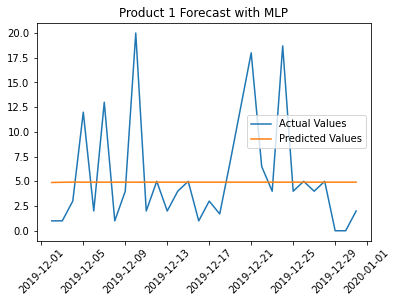

Test RMSE: 5.579


In [240]:
# Product 1
plt.plot(prod_testY['dates'], prod_testY['quantity'], label="Actual Values")
plt.plot(df_forecast['dates'], df_forecast['quantity'], label="Predicted Values")
plt.xticks(rotation = 45)
plt.ylabel
plt.legend()
plt.title(f'Product {num_product} Forecast with MLP')
plt.show()
# evaluate forecasts
rmse = sqrt(mean_squared_error(prod_testY['quantity'],df_forecast['quantity']))
print('Test RMSE: %.3f' % rmse)

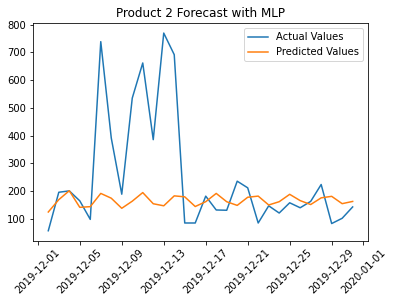

Test RMSE: 221.597


In [322]:
# Product 2
plt.plot(prod_testY['dates'], prod_testY['quantity'], label="Actual Values")
plt.plot(df_forecast['dates'], df_forecast['quantity'], label="Predicted Values")
plt.xticks(rotation = 45)
plt.ylabel
plt.legend()
plt.title(f'Product {num_product} Forecast with MLP')
plt.show()
# evaluate forecasts
rmse = sqrt(mean_squared_error(prod_testY['quantity'],df_forecast['quantity']))
print('Test RMSE: %.3f' % rmse)

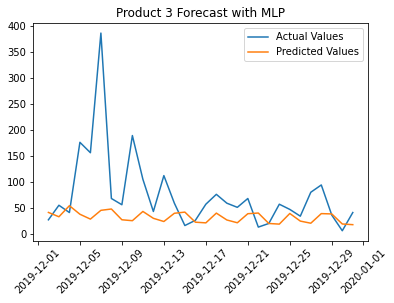

Test RMSE: 83.320


In [384]:
# Product 3
plt.plot(prod_testY['dates'], prod_testY['quantity'], label="Actual Values")
plt.plot(df_forecast['dates'], df_forecast['quantity'], label="Predicted Values")
plt.xticks(rotation = 45)
plt.ylabel
plt.legend()
plt.title(f'Product {num_product} Forecast with MLP')
plt.show()
# evaluate forecasts
rmse = sqrt(mean_squared_error(prod_testY['quantity'],df_forecast['quantity']))
print('Test RMSE: %.3f' % rmse)

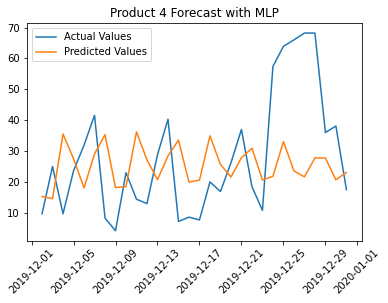

Test RMSE: 20.701


In [417]:
# Product 4
plt.plot(prod_testY['dates'], prod_testY['quantity'], label="Actual Values")
plt.plot(df_forecast['dates'], df_forecast['quantity'], label="Predicted Values")
plt.xticks(rotation = 45)
plt.ylabel
plt.legend()
plt.title(f'Product {num_product} Forecast with MLP')
plt.show()
# evaluate forecasts
rmse = sqrt(mean_squared_error(prod_testY['quantity'],df_forecast['quantity']))
print('Test RMSE: %.3f' % rmse)